# Estimate a flooding probability

In this example, we estimate the probability that the ouput of a function exceeds a given threshold with the FORM method. We consider the flooding model.

## Introduction

The following figure presents a dyke protecting industrial facilities. When the river level exceeds the dyke height, flooding occurs. The model is based on a crude simplification of the 1D hydrodynamical equations of Saint-Venant under the assumptions of uniform and constant flow rate and large rectangular sections.

![Flooding section](flooding_section.png)

Four independent random variables are considered:

 - $Q$: flow rate [m^3 s^-1]
 - $K_s$: Strickler [m^1/3 s^-1]
 - $Z_v$: downstream height [m]
 - $Z_m$: upstream height [m]

When the Strickler coefficient increases, the riverbed generates less friction. 

The model depends on four parameters:

* the height of the dyke: $H_d = 3$ [m],
* the altitude of the river banks: $Z_b = 55.5$ [m],
* the river length: $L = 5000$ [m],
* the river width: $B = 300$ [m].

The altitude of the dyke is:

$$
Z_d = Z_b + H_d
$$

The slope $\alpha$ of the river is assumed to be close to zero, which implies:

$$
\alpha = \frac{Z_m - Z_v}{L},
$$

if $Z_m \geq Z_v$. 

The water depth is:

$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$

for any $K_s, Q>0$.

The flood altitude is:

$$
Z_c = H + Z_v.
$$

The altitude of the surface of the water is greater than the altitude of the top of the dyke (i.e. there is a flood) if:

$$
S = Z_c - Z_d
$$

is greater than zero.

The following figure presents the model with more details. 

![Flooding section details](flooding_section_detail.png)

If we substitute the parameters into the equation, we get:

$$
S = \left(\frac{Q}{300 Ks \sqrt{(Zm-Zv)/5000}}\right)^{3/5} +Zv-58.5.
$$

We assume that the four inputs have the following distributions:

 - $Q$ ~ Gumbel(mode=1013, scale=558), $Q$ > 0
 - $K_s$ ~ Normal(mu=30.0, sigma=7.5), $K_s$ > 0
 - $Z_v$ ~ Uniform(a=49, b=51)
 - $Z_m$ ~ Uniform(a=54, b=56)

Moreover, we assume that the input random variables are independent.

We want to estimate the flood probability:

$$
P_f = P(S>0).
$$

## References

* Iooss B, Lemaître P (2015) A review on global sensitivity analysis methods. In: Meloni C., Dellino G. (eds) Uncertainty management in Simulation-Optimization of Complex Systems: Algorithmsand Applications, Springer
* Baudin M., Dutfoy A., Iooss B., Popelin AL. (2015) OpenTURNS: An Industrial Software for Uncertainty Quantification in Simulation. In: Ghanem R., Higdon D., Owhadi H. (eds) Handbook of Uncertainty Quantification. Springer

## Define the model

In [1]:
from __future__ import print_function
import openturns as ot

Create the marginal distributions of the parameters. 

In [2]:
dist_Q = ot.TruncatedDistribution(ot.Gumbel(558., 1013.), 0, ot.TruncatedDistribution.LOWER)
dist_Ks = ot.TruncatedDistribution(ot.Normal(30.0, 7.5), 0, ot.TruncatedDistribution.LOWER)
dist_Zv = ot.Uniform(49.0, 51.0)
dist_Zm = ot.Uniform(54.0, 56.0)
marginals = [dist_Q, dist_Ks, dist_Zv, dist_Zm]

Create the joint probability distribution. 

In [3]:
distribution = ot.ComposedDistribution(marginals)
distribution.setDescription(['Q', 'Ks', 'Zv', 'Zm'])

Create the model. 

In [4]:
model = ot.SymbolicFunction(['Q', 'Ks', 'Zv', 'Zm'],
                            ['(Q/(Ks*300.*sqrt((Zm-Zv)/5000)))^(3.0/5.0)+Zv-58.5'])

## Define the event

Then we create the event whose probability we want to estimate.

In [5]:
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.ThresholdEvent(G, ot.Greater(), 0.0)
event.setName('overflow')

## Estimate the probability with FORM

Define a solver. 

In [6]:
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

Run FORM. 

In [7]:
startingPoint = distribution.getMean()
algo = ot.FORM(optimAlgo, event, startingPoint)
algo.run()
result = algo.getResult()
standardSpaceDesignPoint = result.getStandardSpaceDesignPoint()

Retrieve results. 

In [8]:
result = algo.getResult()
probability = result.getEventProbability()
print('Pf=', probability)

Pf= 0.0005340887806479517


Importance factors. 

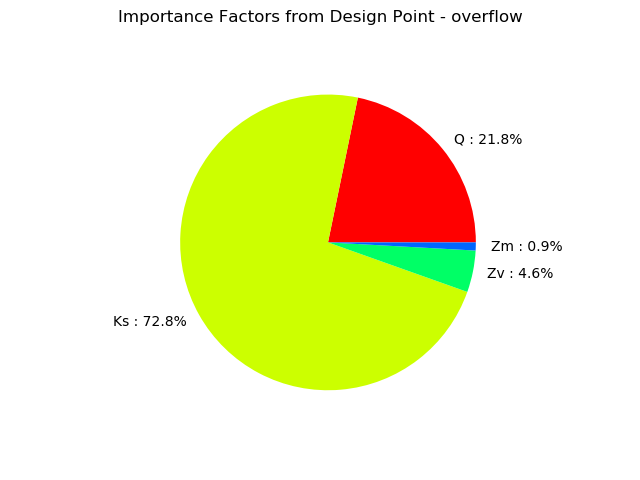

In [9]:
result.drawImportanceFactors()